cuda


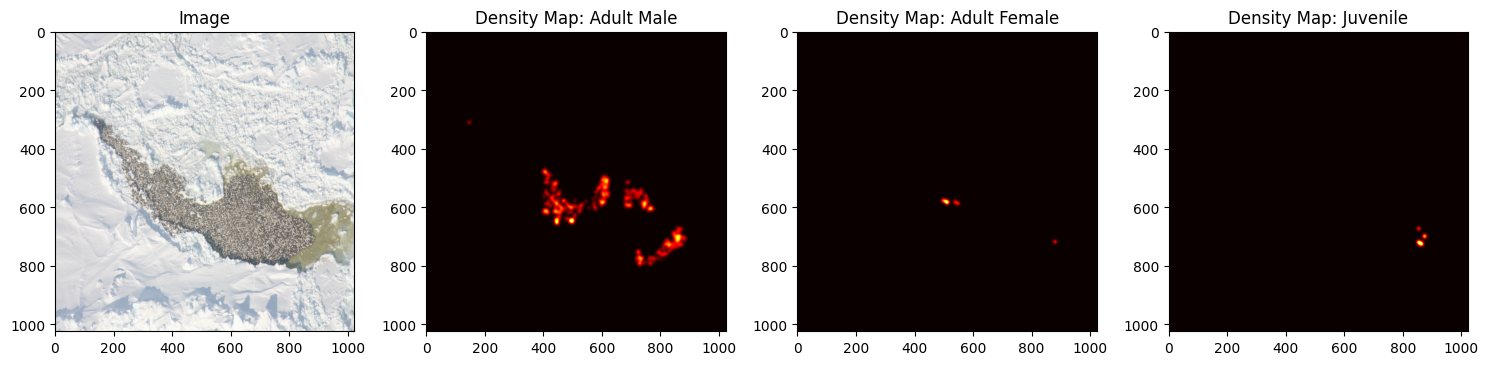

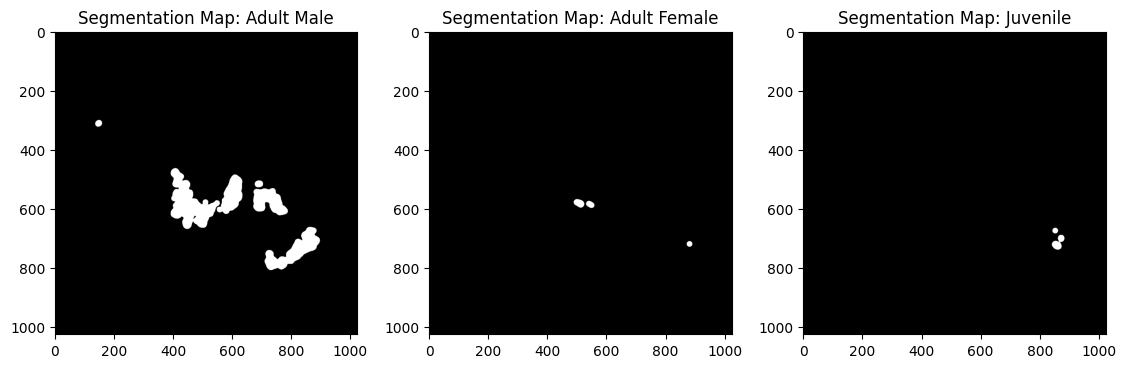

In [2]:
import os
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

from models.unet import UNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Paths
image_dir = "labelstudio-export/images"
annotations_path = "labelstudio-export/annotations.json"
output_dir = "labelstudio-export/annotated-images"

# Parameters
min_annotations = 200  # Minimum annotations threshold
sigma = 5  # For Gaussian blur

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Define a color map for different keypoint labels
class_to_idx = {
    'Adult Male': 0,
    'Adult Female': 1,
    'Juvenile': 2
}

# Gaussian kernel to generate density maps
def generate_density_map(height, width, points, sigma=10):
    density_map = np.zeros((height, width), dtype=np.float32)
    
    for point in points:
        x = int(point['x'] * width / 100)
        y = int(point['y'] * height / 100)
        if 0 <= x < width and 0 <= y < height:
            density_map[y, x] += 1
            
    return gaussian_filter(density_map, sigma=sigma)

# Dataset
class EiderDuckDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform
        self.filtered_annotations = self.filter_annotations()

    def filter_annotations(self):
        filtered = []
        for annotation in self.annotations:
            valid_annotations = [ann for ann in annotation['annotations'] if not ann['was_cancelled']]
            if valid_annotations and len(valid_annotations[0]['result']) >= min_annotations:
                filtered.append(annotation)
        return filtered
    
    def __len__(self):
        return len(self.filtered_annotations)

    def __getitem__(self, idx):
        annotation = self.filtered_annotations[idx]
        
        # Image
        image_file = annotation['file_upload']
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        
        # Create density maps (one per class)
        density_maps = np.zeros((3, 1024, 1024), dtype=np.float32)
        points = {'Adult Male': [], 'Adult Female': [], 'Juvenile': []}
        
        # Extract annotations
        for result in annotation['annotations'][0]['result']:
            if result['type'] == 'keypointlabels':
                label = result['value']['keypointlabels'][0]
                if label in class_to_idx:
                    points[label].append({'x': result['value']['x'], 'y': result['value']['y']})
        
        # Generate density maps for each class
        for label, point_list in points.items():
            # Check if the label exists in the mapping
            class_idx = class_to_idx[label]
            density_maps[class_idx] = generate_density_map(1024, 1024, point_list, sigma=sigma)

        # Transform image and density maps to tensors
        if self.transform:
            image = self.transform(image)

        density_maps = torch.from_numpy(density_maps)
        segmentation_maps = (density_maps > 1e-3).float()

        return image, density_maps, segmentation_maps

# Create dataset and dataloader with resizing
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((1024, 1024)),  # Resize all images to 256x256
    torchvision.transforms.ToTensor()
])
dataset = EiderDuckDataset(annotations, image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Plot one sample
image, density_maps, segmentation_maps = dataset[0]

# Plot the image
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Image')

# Plot the density maps
for i, label in enumerate(class_to_idx.keys()):
    plt.subplot(1, 4, i + 2)
    plt.imshow(density_maps[i], cmap='hot')
    plt.title(f'Density Map: {label}')

plt.tight_layout()
plt.show()

# Plot the segmentation maps
plt.figure(figsize=(15, 5))
for i, label in enumerate(class_to_idx.keys()):
    plt.subplot(1, 4, i + 1)
    plt.imshow(segmentation_maps[i], cmap='gray')
    plt.title(f'Segmentation Map: {label}')

plt.tight_layout()
plt.show()
